In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc

import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from face_verification.facenet import basenet
from face_verification.facenet import triplet_net
from face_verification.facenet import triplet_loss
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Dictionary

In [2]:
vgg2_train = pd.read_csv('./images/vgg2_train_path.csv')
vgg2_test = pd.read_csv('./images/vgg2_test_path.csv')

print('Train:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_train['name'].unique()), 
                                                           len(vgg2_train)))
print('Test:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_test['name'].unique()),
                                                          len(vgg2_test)))

vgg2_train.head()

Train:	# person = 8631	 # images = 2113881
Test:	# person =  500	 # images =  116568


,name,path
0,n000002,./images/vgg2_face/train/n000002/0054_01.jpg
1,n000002,./images/vgg2_face/train/n000002/0029_01.jpg
2,n000002,./images/vgg2_face/train/n000002/0202_02.jpg
3,n000002,./images/vgg2_face/train/n000002/0037_01.jpg
4,n000002,./images/vgg2_face/train/n000002/0046_01.jpg


In [3]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [4]:
vgg2_train_df = vgg2_train.groupby('name').apply(path_to_list).reset_index()
vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

vgg2_train_df.head()

,name,count,paths
0,n000002,198,"[./images/vgg2_face/train/n000002/0054_01.jpg,..."
1,n000003,143,"[./images/vgg2_face/train/n000003/0054_01.jpg,..."
2,n000004,334,"[./images/vgg2_face/train/n000004/0054_01.jpg,..."
3,n000005,67,"[./images/vgg2_face/train/n000005/0430_02.jpg,..."
4,n000006,374,"[./images/vgg2_face/train/n000006/0154_01.jpg,..."


# Define Triplet Network

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [6]:
# create the base-cnn model
base_model = basenet(output_shape=128)

# # visualization
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.png')
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.pdf')

# base-model summary
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________

In [7]:
# create the triplet-network model
triplet_model = triplet_net(base_model=base_model, input_shape=(96, 96, 3))

# # visualization
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.png')
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.pdf')

# base-model summary
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          3743280     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Triplet Network Training

In [ ]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 900:
        lr *= 1e-1
    elif epoch > 800:
        lr *= 2e-1
    elif epoch > 700:
        lr *= 3e-1
    elif epoch > 600:
        lr *= 4e-1
    elif epoch > 500:
        lr *= 5e-1
    elif epoch > 400:
        lr *= 6e-1
    elif epoch > 300:
        lr *= 7e-1
    elif epoch > 200:
        lr *= 8e-1
    elif epoch > 100:
        lr *= 9e-1
        
    return lr

In [8]:
# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = './models/margin-02-' + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.2))

# define training and test dataset image generator
train_generator = train_triplet_generator(vgg2_train_df, batch_size=128)
test_generator = test_triplet_generator(vgg2_test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 ./models/margin-02-20180801-0231


In [9]:
# fit the model
history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs=1000, 
                                      validation_data=test_generator, validation_steps=50, 
                                      verbose=2, callbacks=callbacks)

base_model.save(path + '/facenet-model.h5')
pickle.dump(history.history, open(path + '/facenet-history.p', 'wb'))
_ = gc.collect()

Epoch 1/500
 - 105s - loss: 20.1298 - val_loss: 14.6981
Epoch 2/500
 - 87s - loss: 16.4426 - val_loss: 16.5274
Epoch 3/500
 - 87s - loss: 13.9184 - val_loss: 14.7014
Epoch 4/500
 - 87s - loss: 13.0128 - val_loss: 13.0908
Epoch 5/500
 - 87s - loss: 11.8748 - val_loss: 11.1117
Epoch 6/500
 - 87s - loss: 11.3655 - val_loss: 11.5529
Epoch 7/500
 - 87s - loss: 10.9863 - val_loss: 10.7576
Epoch 8/500
 - 87s - loss: 10.3107 - val_loss: 10.7718
Epoch 9/500
 - 87s - loss: 10.1106 - val_loss: 10.6467
Epoch 10/500
 - 87s - loss: 9.7116 - val_loss: 8.7275
Epoch 11/500
 - 87s - loss: 9.8321 - val_loss: 13.8691
Epoch 12/500
 - 87s - loss: 9.6536 - val_loss: 10.7479
Epoch 13/500
 - 87s - loss: 8.9436 - val_loss: 8.8798
Epoch 14/500
 - 87s - loss: 8.8962 - val_loss: 9.0015
Epoch 15/500
 - 87s - loss: 8.4263 - val_loss: 8.4295
Epoch 16/500
 - 87s - loss: 8.3537 - val_loss: 7.9556
Epoch 17/500
 - 87s - loss: 8.5853 - val_loss: 8.2170
Epoch 18/500
 - 87s - loss: 8.3324 - val_loss: 7.1110
Epoch 19/500
 - 

Epoch 152/500
 - 87s - loss: 3.8659 - val_loss: 3.6934
Epoch 153/500
 - 87s - loss: 3.9123 - val_loss: 4.3372
Epoch 154/500
 - 87s - loss: 3.9254 - val_loss: 4.4032
Epoch 155/500
 - 87s - loss: 3.7377 - val_loss: 3.8956
Epoch 156/500
 - 87s - loss: 3.7590 - val_loss: 4.5286
Epoch 157/500
 - 87s - loss: 3.8801 - val_loss: 3.5558
Epoch 158/500
 - 87s - loss: 4.0023 - val_loss: 4.2280
Epoch 159/500
 - 87s - loss: 3.9890 - val_loss: 3.3866
Epoch 160/500
 - 87s - loss: 3.9352 - val_loss: 4.2982
Epoch 161/500
 - 87s - loss: 4.0204 - val_loss: 4.1889
Epoch 162/500
 - 87s - loss: 4.2151 - val_loss: 3.9961
Epoch 163/500
 - 87s - loss: 3.8099 - val_loss: 4.4555
Epoch 164/500
 - 87s - loss: 3.8875 - val_loss: 3.6636
Epoch 165/500
 - 87s - loss: 4.0995 - val_loss: 3.6562
Epoch 166/500
 - 87s - loss: 3.6720 - val_loss: 3.4877
Epoch 167/500
 - 87s - loss: 4.0383 - val_loss: 3.9133
Epoch 168/500
 - 87s - loss: 3.9602 - val_loss: 3.4840
Epoch 169/500
 - 87s - loss: 4.0240 - val_loss: 4.1703
Epoch 170/

Epoch 301/500
 - 87s - loss: 3.2675 - val_loss: 3.2913
Epoch 302/500
 - 87s - loss: 2.9915 - val_loss: 3.2093
Epoch 303/500
 - 87s - loss: 2.9310 - val_loss: 2.5960
Epoch 304/500
 - 87s - loss: 2.9022 - val_loss: 3.1725
Epoch 305/500
 - 87s - loss: 3.0802 - val_loss: 2.5824
Epoch 306/500
 - 87s - loss: 2.9411 - val_loss: 2.4298
Epoch 307/500
 - 87s - loss: 2.9362 - val_loss: 2.4632
Epoch 308/500
 - 87s - loss: 2.8978 - val_loss: 3.0457
Epoch 309/500
 - 87s - loss: 2.9951 - val_loss: 3.0387
Epoch 310/500
 - 87s - loss: 2.6684 - val_loss: 2.7105
Epoch 311/500
 - 87s - loss: 2.9634 - val_loss: 2.9979
Epoch 312/500
 - 87s - loss: 2.8489 - val_loss: 2.7308
Epoch 313/500
 - 87s - loss: 2.9389 - val_loss: 2.5190
Epoch 314/500
 - 87s - loss: 3.0804 - val_loss: 2.3534
Epoch 315/500
 - 87s - loss: 3.0110 - val_loss: 3.0942
Epoch 316/500
 - 87s - loss: 2.8806 - val_loss: 2.7264
Epoch 317/500
 - 87s - loss: 2.9205 - val_loss: 2.6145
Epoch 318/500
 - 87s - loss: 2.7100 - val_loss: 3.2061
Epoch 319/

Epoch 450/500
 - 87s - loss: 2.2329 - val_loss: 2.3451
Epoch 451/500
 - 87s - loss: 2.4332 - val_loss: 2.1193
Epoch 452/500
 - 87s - loss: 2.3043 - val_loss: 2.1100
Epoch 453/500
 - 87s - loss: 2.3711 - val_loss: 2.2175
Epoch 454/500
 - 87s - loss: 2.2217 - val_loss: 2.7534
Epoch 455/500
 - 87s - loss: 2.4210 - val_loss: 2.2869
Epoch 456/500
 - 87s - loss: 2.2841 - val_loss: 2.3695
Epoch 457/500
 - 87s - loss: 2.3014 - val_loss: 2.2240
Epoch 458/500
 - 87s - loss: 2.3455 - val_loss: 3.0957
Epoch 459/500
 - 87s - loss: 2.2029 - val_loss: 2.1542
Epoch 460/500
 - 87s - loss: 2.2481 - val_loss: 2.2059
Epoch 461/500
 - 87s - loss: 2.4038 - val_loss: 2.1338
Epoch 462/500
 - 87s - loss: 2.3847 - val_loss: 2.1761
Epoch 463/500
 - 87s - loss: 2.4802 - val_loss: 2.3011
Epoch 464/500
 - 87s - loss: 2.4983 - val_loss: 2.4684
Epoch 465/500
 - 87s - loss: 2.3792 - val_loss: 2.6235
Epoch 466/500
 - 87s - loss: 2.4660 - val_loss: 2.4137
Epoch 467/500
 - 87s - loss: 2.5955 - val_loss: 2.1208
Epoch 468/

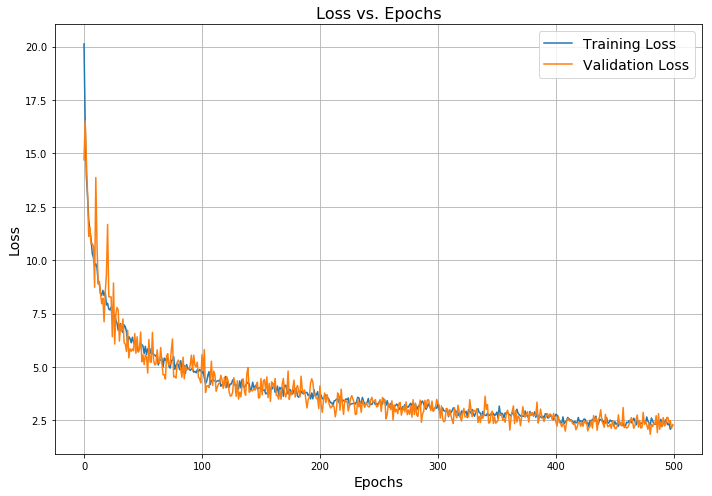

In [10]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()